In [2]:
import numpy as np 
import mne
import os
from scipy import signal
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import utils as np_utils
from sklearn.model_selection import train_test_split
from EEGModels import EEGNet, DeepConvNet
# from htnet_model import htnet
import autokeras as ak

In [3]:
path=os.path.abspath(os.path.join(os.path.dirname(" __file__" ), '../..', 'bci3_npz'))
data=np.load(path+"/"+"bci_3.npz")
X=data['X']
events=data['events']
event_dict=dict(finger=-1, tongue=1)
# X_test=data['X_test']
n_channels=X.shape[1]
s_freq=1000
info=mne.create_info(n_channels,sfreq=s_freq)
epochs=mne.EpochsArray(X,info)
# epochs.plot(picks='misc')

Not setting metadata
Not setting metadata
278 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [4]:
y=events.squeeze()
print(X.shape, y.shape)

(278, 64, 3000) (278,)


In [6]:
new_X=np.empty([278,64,750])
for i in range(0,278):
    for j in range(0,64):
        array=X[i,j,:]
        array=array.astype('float64')
        new_X[i,j,:]=signal.resample(array,750)

In [5]:
# X_train      = X[0:139,]
# Y_train      = y[0:139]
# X_validate   = X[139:208,]
# Y_validate   = y[139:208]
# X_test       = X[208:,]
# Y_test       = y[208:]

X_train, X_validate, Y_train, Y_validate=train_test_split(new_X,y,test_size=0.2,random_state=42)

In [8]:
kernels, chans, samples = 1, 64, 750

Y_train      = np_utils.to_categorical((Y_train+1)/2)
Y_validate   = np_utils.to_categorical((Y_validate+1)/2)
# Y_test       = np_utils.to_categorical((Y_test+1)/2)

# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples,kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
# X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

In [9]:
print(Y_train.sum(axis=0),Y_validate.sum(axis=0))

[110. 112.] [29. 27.]


In [74]:
initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

In [75]:
# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
# model configurations may do better, but this is a good starting point)
model = EEGNet(nb_classes = 2, Chans = chans, Samples = samples, dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')
# model= DeepConvNet(nb_classes=2, Chans = chans, Samples = samples,dropoutRate = 0.3)
# model = htnet(nb_classes = 2, Chans = chans, Samples = samples, dropoutRate = 0.5, kernLength = 64, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')


# compile the model and set the optimizers
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath='checkpoint.h5', verbose=1,save_best_only=True)


fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 100, verbose = 2, validation_data=(X_validate, Y_validate),callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1) ,checkpointer])

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.009999999776482582.
14/14 - 4s - loss: 0.7203 - accuracy: 0.4595 - val_loss: 0.6906 - val_accuracy: 0.6786

Epoch 00001: val_loss improved from inf to 0.69059, saving model to checkpoint.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.009998999876494932.
14/14 - 3s - loss: 0.6947 - accuracy: 0.5045 - val_loss: 0.6892 - val_accuracy: 0.6607

Epoch 00002: val_loss improved from 0.69059 to 0.68923, saving model to checkpoint.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.009997000136010244.
14/14 - 3s - loss: 0.6874 - accuracy: 0.5631 - val_loss: 0.6884 - val_accuracy: 0.6964

Epoch 00003: val_loss improved from 0.68923 to 0.68844, saving model to checkpoint.h5
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.009994001785933966.
14/14 - 3s - loss: 0.6834 - accuracy: 0.5991 - val_loss: 0.6858 - val_accuracy: 0.6607

Epoch 00004: v

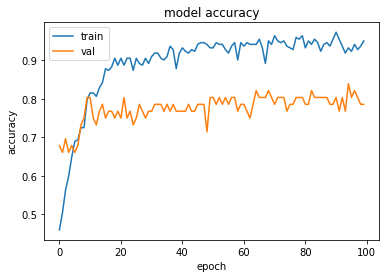

In [76]:
plt.figure(0)
plt.plot(fittedModel.history['accuracy'])
plt.plot(fittedModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

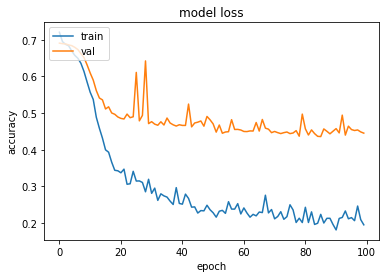

In [77]:
plt.figure(1)
plt.plot(fittedModel.history['loss'])
plt.plot(fittedModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
# model.load_weights('checkpoint.h5')
# probs       = model.predict(X_test)
# preds       = probs.argmax(axis = -1)  
# acc         = np.mean(preds == Y_test.argmax(axis=-1))
# print("Classification accuracy: %f " % (acc))

In [78]:
test_data=data['X_test']
true_labels=np.loadtxt('true_labels.txt')
print(test_data.shape,true_labels.shape)

(100, 64, 3000) (100,)


In [79]:
model.load_weights('checkpoint.h5')
new_test_data=np.empty([100,64,750])
for i in range(0,100):
    for j in range(0,64):
        array=test_data[i,j,:]
        array=array.astype('float64')
        new_test_data[i,j,:]=signal.resample(array,750)
new_test_data= new_test_data.reshape(new_test_data.shape[0], chans, samples, kernels)
true_labels= np_utils.to_categorical((true_labels+1)/2)


In [80]:
probs_test=model.predict(new_test_data)
preds_test=probs_test.argmax(axis=-1)
acc_test=np.mean(preds_test==true_labels.argmax(axis=-1))
print("Test Accuracy: %f"% (acc_test))


Test Accuracy: 0.530000


In [8]:
clf = ak.ImageClassifier(overwrite=True, max_trials=1)
clf.fit(new_X, y, epochs=10)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

KeyboardInterrupt: 